# RoPE 旋转位置编码
这一部分项目的b站讲解视频已经很清楚了，同时项目给出的文档中的内容，也就是对第一篇博客的内容的浓缩，如果对更详细内容感兴趣可以看博客。

参考博客

[十分钟读懂旋转编码(RoPE)](https://zhuanlan.zhihu.com/p/647109286)

[一文看懂 LLaMA 中的旋转式位置编码（Rotary Position Embedding）(包含代码及详细数学推导)](https://zhuanlan.zhihu.com/p/642884818)

## 1. 位置编码基本过程
当输入的文字序列经过tokenizer和embedding之后，在做self-attention之前会经过线性变化，同时**集成位置信息**得到qkv。
### 1.1 为什么要集成位置信息？
因为如果不继承位置信息，将句子中的任意两个token交换位置，得到的注意力分数不变，但句子的语义可能改变了

---

## 2. 集成位置信息的方法
### 2.1 绝对位置编码
在计算kqv之前，计算一个位置编码向量，然后加到词嵌入向量上
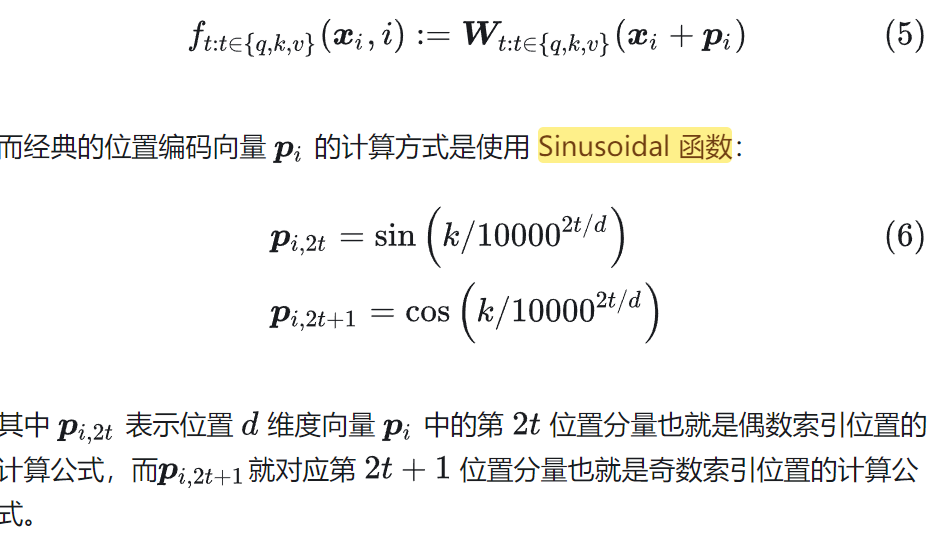

---

### 2.2 旋转位置编码
#### 2.2.1 原理
RoPE的目标是**通过绝对位置编码的方式实现相对位置编码**,假设通过下述运算来给q,k添加**绝对位置信息**:

$$\begin{equation}\tilde{\boldsymbol{q}}_m = \boldsymbol{f}(\boldsymbol{q}, m), \quad\tilde{\boldsymbol{k}}_n = \boldsymbol{f}(\boldsymbol{k}, n)\end{equation}
$$

这样,经过该操作后,q,k就带有了位置m,n的绝对位置信息.
而Attention的核心运算是内积,所以要想让内积的结果带有相对位置信息,就需要以下恒等关系:

$$\begin{equation}\langle\boldsymbol{f}(\boldsymbol{q}, m), \boldsymbol{f}(\boldsymbol{k}, n)\rangle = g(\boldsymbol{q},\boldsymbol{k},m-n)\end{equation}
$$

也就是说，需要找到f和g函数，使得**内积之后的结果和两个词嵌入向量有关，也和相对位置（m-n）有关**。

可以通过复数运算与角的关系启发（可以看博客）,想到如下的对二维形式的编码方法:

$$\begin{equation} 
\boldsymbol{f}(\boldsymbol{q}, m) =\begin{pmatrix}\cos m\theta & -\sin m\theta\\ \sin m\theta & \cos m\theta\end{pmatrix} \begin{pmatrix}q_0 \\ q_1\end{pmatrix}\end{equation}
$$

也就是对q向量进行一个旋转变换，这个旋转变换的角度是和该q向量的绝对位置m相关的

由于内积满足**线性叠加性**,因此任意偶数维的RoPE,我们都可以表示为二维情形的**拼接**,即:

$$\begin{equation}\scriptsize{\underbrace{\begin{pmatrix} 
\cos m\theta_0 & -\sin m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ 
\sin m\theta_0 & \cos m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ 
0 & 0 & \cos m\theta_1 & -\sin m\theta_1 & \cdots & 0 & 0 \\ 
0 & 0 & \sin m\theta_1 & \cos m\theta_1 & \cdots & 0 & 0 \\ 
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ 
0 & 0 & 0 & 0 & \cdots & \cos m\theta_{d/2-1} & -\sin m\theta_{d/2-1} \\ 
0 & 0 & 0 & 0 & \cdots & \sin m\theta_{d/2-1} & \cos m\theta_{d/2-1} \\ 
\end{pmatrix}}_{\boldsymbol{\mathcal{R}}_m} \begin{pmatrix}q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1}\end{pmatrix}}\end{equation}
$$

也就是说,给位置为m的向量q乘上矩阵$R_m$,位置为n的向量k乘上矩阵$R_n$,用变换后的Q,K序列做Attention,那么Attention就自动包含相对位置信息了,因为成立恒等式:

$$\begin{equation}(\boldsymbol{\mathcal{R}}_m \boldsymbol{q})^{\top}(\boldsymbol{\mathcal{R}}_n \boldsymbol{k}) =  \boldsymbol{q}^{\top} \boldsymbol{\mathcal{R}}_m^{\top}\boldsymbol{\mathcal{R}}_n \boldsymbol{k} = \boldsymbol{q}^{\top} \boldsymbol{\mathcal{R}}_{n-m} \boldsymbol{k}\end{equation}
$$

值得指出的是,$R_m$是一个正交矩阵,它不会改变向量的模长,因此通常来说它不会改变原模型的稳定性.
由于$R_m$的**稀疏性**（0很多）,所以直接用矩阵乘法来实现会很浪费算力,原作者推荐通过下述方式来实现RoPE:

$$\begin{equation}\begin{pmatrix}q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1} 
\end{pmatrix}\otimes\begin{pmatrix}\cos m\theta_0 \\ \cos m\theta_0 \\ \cos m\theta_1 \\ \cos m\theta_1 \\ \vdots \\ \cos m\theta_{d/2-1} \\ \cos m\theta_{d/2-1} 
\end{pmatrix} + \begin{pmatrix}-q_1 \\ q_0 \\ -q_3 \\ q_2 \\ \vdots \\ -q_{d-1} \\ q_{d-2} 
\end{pmatrix}\otimes\begin{pmatrix}\sin m\theta_0 \\ \sin m\theta_0 \\ \sin m\theta_1 \\ \sin m\theta_1 \\ \vdots \\ \sin m\theta_{d/2-1} \\ \sin m\theta_{d/2-1} 
\end{pmatrix}\end{equation}
$$

其中$\otimes$是逐位对应相乘



##### 2.2.2 RoPE的效果
1. 在$\theta_i$的选择上,RoPE同样沿用了Sinusoidal位置编码的方案,即$\theta_i = 10000^{-2i/d}$,它可以带来一定的**远程衰减性**（随着相对距离的变大，内积结果有衰减趋势， 具体证明可见博客）
2. RoPE 可以通过旋转矩阵来实现位置编码的**外推**（测试用的句子长度长于训练用句子长度时，模型的维持表现的能力），即可以通过旋转矩阵来生成超过预期训练长度的位置编码。这样可以提高模型的泛化能力和鲁棒性。

##### 2.2.3 总结
所以简单来说 RoPE 的 self-attention 操作的流程是，对于 token 序列中的每个词嵌入向量，首先计算其对应的 query 和 key 向量，然后对每个 token 位置都计算对应的旋转位置编码，接着对每个 token 位置的 query 和 key 向量的元素按照 两两一组 应用旋转变换，最后再计算 query 和 key 之间的内积得到 self-attention 的计算结果。

#### 本项目代码

In [ ]:
import jax.numpy as jnp
import numpy as np
from einops import rearrange, repeat


def fixed_pos_embedding(x, seq_dim=0):
    dim = x.shape[-1]
    inv_freq = 1.0 / (10000 ** (np.arange(0, dim, 2) / dim)) # 计算theta_i

    sinusoid_inp = np.einsum("i , j -> i j", np.arange(x.shape[seq_dim]), inv_freq)

    return np.sin(sinusoid_inp), np.cos(sinusoid_inp)


def rotate_every_two(x):
    x1 = x[:, :, ::2]
    x2 = x[:, :, 1::2]

    x = jnp.stack((-x2, x1), axis=-1)

    return rearrange(x, "... d j -> ... (d j)")


def apply_rotary_pos_emb(x, sincos):
    sin, cos = map(lambda t: repeat(t, "b n -> b (n j)", j=2)[:, None, :], sincos)
    return (x * cos) + (rotate_every_two(x) * sin)